In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class ScaledWindowedVariance:
    """
    This implementation is based on the paper:
    "Evaluating scaled windowed variance methods for estimating
    the Hurst coefficient of time series" from Physica A. 1997 July 15; 241(3-4): 606–626.
    """
    def __init__(self, data: pd.Series, 
                min_window: int = 2, 
                max_window: int = None, 
                custom_window_list: list = None):
        """
        ScaledWindowedVariance calculates the scaled windowed variance of a time series.
        It allows for different methods of calculation and can exclude certain values based on the method.

        Parameters:
        data (pd.Series): The time series data to analyze.
        min_window (int): The minimum window size for the rolling calculation.
        max_window (int): The maximum window size for the rolling calculation.
        custom_window_list (list): A custom list of window sizes to use instead of the default range.
        """

        self.data = data
        
        self.N = len(data)
        if self.N < 2:
            raise ValueError("Data must contain at least two points.")
        
        self.min_window = int(np.log2(min_window))
        self.max_window = int(np.floor(np.log2(self.N))) if max_window is None else int(np.log2(max_window))

        print(f"Data length: {self.N}, Min window: {min_window}, Max window: {self.max_window}")
        self.window_sizes = 2 ** np.arange(self.min_window, self.max_window + 1)
    
    def _manage_detrending(self, window):
        """Apply the appropriate detrending method."""
        if self.method == 'SD':
            return window
        elif self.method == 'LD':    
            return self._detrend_linear(window)
        elif self.method == 'BD':
            return self._detrend_bridge(window)

    def _detrend_linear(self, window):
        """Remove linear trend from window using regression."""
        x = np.arange(len(window))
        slope, intercept = np.polyfit(x, window, 1)
        trend = slope * x + intercept
        return window - trend

    def _detrend_bridge(self, window):
        """Remove bridge trend from window."""
        if len(window) < 2:
            return window
        x = np.arange(len(window))
        first, last = window[0], window[-1]
        trend = np.linspace(first, last, len(window))
        return window - trend
        
    def _find_exclusions_bounds(self):
        """Determine the exclusions based on the method."""

        if self.exclusions is False:
            return 0, 0
        
        lower_window_exclusion = {"SD": [0, 0], "LD": [1, 0], "BD": [1, 0]}

        exclusions_dict = {
            6: {"SD": [0, 2], "LD": [2, 0], "BD": [1, 0]},
            7: {"SD": [0, 3], "LD": [2, 1], "BD": [1, 0]},
            8: {"SD": [0, 3], "LD": [2, 2], "BD": [1, 0]},
            9: {"SD": [1, 4], "LD": [2, 2], "BD": [2, 2]},
            10: {"SD": [1, 4], "LD": [2, 2], "BD": [2, 3]},
            11: {"SD": [1, 5], "LD": [3, 4], "BD": [2, 4]},
            12: {"SD": [1, 5], "LD": [3, 5], "BD": [2, 4]},
            13: {"SD": [2, 6], "LD": [3, 5], "BD": [2, 5]},
            14: {"SD": [2, 7], "LD": [4, 5], "BD": [3, 6]},
            15: {"SD": [2, 7], "LD": [5, 5], "BD": [3, 7]},
            16: {"SD": [3, 7], "LD": [6, 5], "BD": [3, 7]},
            17: {"SD": [4, 7], "LD": [7, 5], "BD": [3, 7]},
        }

        if self.max_window in exclusions_dict:
            return exclusions_dict[self.max_window][self.method]
        elif self.max_window > max(exclusions_dict.keys()):
            return exclusions_dict[max(exclusions_dict.keys())][self.method]
        else:
            return lower_window_exclusion[self.method]
        
    def _create_exclusion_mask(self):
        lower_bound, upper_bound = self._find_exclusions_bounds()

        # Création du masque
        mask = np.zeros(len(self.window_sizes), dtype=bool)
        mask[lower_bound:len(self.window_sizes)-upper_bound] = True

        return mask


            
    # def estimate_hurst(self, method: str = 'SD', exclusions: bool = False, plot: bool = False):

    #     self.exclusions = exclusions
    #     self.method = method

    #     if method not in ['SD', 'LD', 'BD']:
    #         raise ValueError("Method must be one of 'SD', 'LD' or 'BD'.")
        
    #     mask = self._create_exclusion_mask()
        
    #     avg_sds = []            # Liste pour stocker l'écart type moyen pour chaque taille de fenêtre
    #     valid_window_sizes = [] # On ne retient que les tailles pour lesquelles la division est possible
        
    #     # Pour chaque taille de fenêtre n
    #     for n in self.window_sizes:
    #         num_windows = self.N // n  # Nombre de fenêtres non chevauchantes

    #         sds = [np.std(self._manage_detrending(self.data[i * n:(i + 1) * n]), ddof=0) for i in range(num_windows)]

    #         avg_sd = np.mean(sds)
    #         avg_sds.append(avg_sd)
    #         valid_window_sizes.append(n)
        
    #     valid_window_sizes = np.array(valid_window_sizes)
    #     avg_sds = np.array(avg_sds)

    #     x = np.log(valid_window_sizes)
    #     y = np.log(avg_sds)

    #     if exclusions:
    #         x = x[mask]
    #         y = y[mask]
    #         slope, intercept = np.polyfit(x, y, 1)
    #     else:
    #         slope, intercept = None, None

    #     slope_all, intercept_all = np.polyfit(x, y, 1)
    #     estimated_H = slope if slope is not None else slope_all

    #     if plot:
    #         import matplotlib.pyplot as plt

    #         plt.figure(figsize=(10, 6))

    #         # Plot non-excluded points in black
    #         plt.scatter(x[mask], y[mask], color='black', label='Non-excluded', zorder=3)

    #         # Plot excluded points in gray
    #         plt.scatter(x[~mask], y[~mask], color='gray', label='Excluded', zorder=2)

    #         # Plot the line for non-excluded points (solid line)
    #         if slope is not None and intercept is not None:
    #             plt.plot(x[mask], slope * x[mask] + intercept, 'k-', label='Fit (non-excluded)', zorder=4)

    #         # Plot the line for all points (dashed line)
    #         plt.plot(x, slope_all * x + intercept_all, 'k--', label='Fit (all)', zorder=1)

    #         plt.xlabel('log(Window Size)')
    #         plt.ylabel('log(Avg SD)')
    #         plt.title('Scaled Windowed Variance')
    #         plt.legend()
    #         plt.grid(True)
    #         plt.show()

    #     return estimated_H

    def estimate_hurst(self, method: str = 'SD', exclusions: bool = False, plot: bool = False):
        self.exclusions = exclusions
        self.method = method

        if method not in ['SD', 'LD', 'BD']:
            raise ValueError("Method must be one of 'SD', 'LD' or 'BD'.")

        # Calcul des tailles de fenêtres valides et des écarts types moyens
        avg_sds = []            # Liste pour stocker l'écart type moyen pour chaque taille de fenêtre
        valid_window_sizes = [] # On ne retient que les tailles pour lesquelles la division est possible

        for n in self.window_sizes:
            num_windows = self.N // n  # Nombre de fenêtres non chevauchantes
            if num_windows < 1:
                continue  # Ignorer les tailles de fenêtres trop grandes

            sds = [np.std(self._manage_detrending(self.data[i * n:(i + 1) * n]), ddof=0) for i in range(num_windows)]

            avg_sd = np.mean(sds)
            avg_sds.append(avg_sd)
            valid_window_sizes.append(n)

        valid_window_sizes = np.array(valid_window_sizes)
        avg_sds = np.array(avg_sds)

        # Génération du masque basé sur les tailles de fenêtres valides
        mask = np.zeros(len(valid_window_sizes), dtype=bool)
        if exclusions:
            lower_bound, upper_bound = self._find_exclusions_bounds()
            mask[lower_bound:len(valid_window_sizes) - upper_bound] = True
        else:
            mask[:] = True  # Pas d'exclusions, tout est inclus

        # Calcul des logarithmes
        x = np.log2(valid_window_sizes)
        y = np.log2(avg_sds)

        # Application du masque
        if exclusions:
            slope, intercept = np.polyfit(x[mask], y[mask], 1)
        else:
            slope, intercept = None, None

        slope_all, intercept_all = np.polyfit(x, y, 1)
        estimated_H = slope if slope is not None else slope_all

        if plot:
            fig, axs = plt.subplots(2, 1, figsize=(10, 12))

            axs[0].plot(self.data, color='black')
            axs[0].set_title('Original Time Series')
            axs[0].grid(True)

            axs[1].scatter(x[mask], y[mask], color='black', label='Non-excluded', zorder=3)
            axs[1].scatter(x[~mask], y[~mask], color='gray', label='Excluded', zorder=2)

            if slope is not None and intercept is not None:
                axs[1].plot(x[mask], slope * x[mask] + intercept, 'k-', label='Fit (non-excluded)', zorder=4)

            axs[1].plot(x, slope_all * x + intercept_all, 'k--', label='Fit (all)', zorder=1)

            axs[1].set_xlabel('log(Window Size)')
            axs[1].set_ylabel('log(Avg SD)')
            axs[1].set_title('Scaled Windowed Variance')
            axs[1].legend()
            axs[1].grid(True)

            plt.tight_layout()
            plt.show()

        return estimated_H, slope_all

Data length: 1024, Min window: 2, Max window: 10


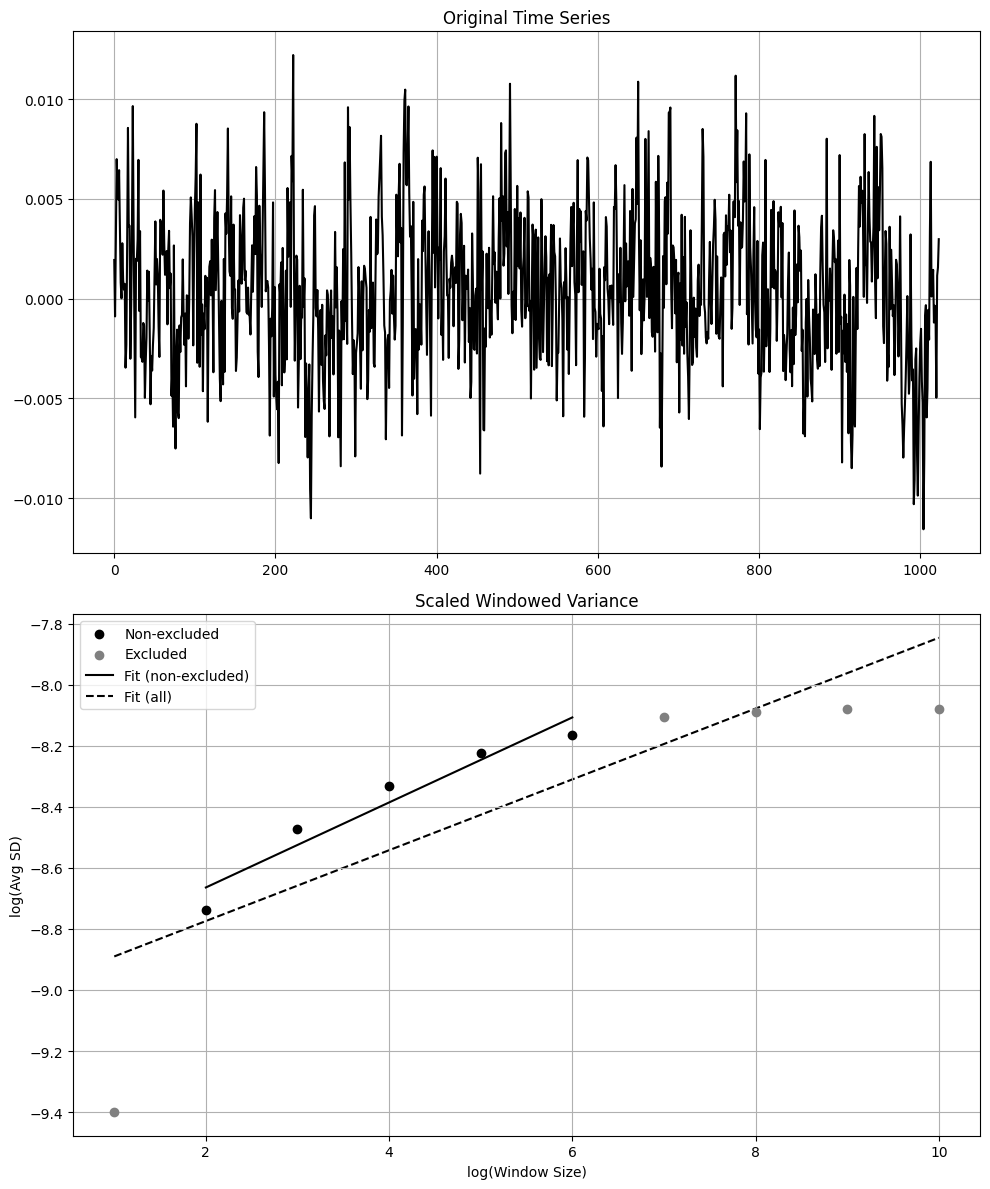

Estimated Hurst exponent: 0.13920129546972934
Estimated Hurst exponent (all): 0.11594606638019128
0.5947712583031413


In [189]:
import sys
sys.path.append('..')
from src.utils import get_config, get_data
from fbm import FBM
from src.ext.HurstIndexSolver import HurstIndexSolver


config = get_config()

# Chargement des données
ftse100 = get_data('ftse100')

N = 1024
H = 0.8

data_type = "fGn" # or "fBm" or signal

f = FBM(N, H)

if data_type == "fGn":
    # Generate a fGn realization
    signal = f.fgn()
elif data_type == "fBm":
    # Generate a fBm realization
    signal = f.fbm()
elif data_type == "signal":
    signal = ftse100.iloc[:N].values

HIS = HurstIndexSolver()
SWV = ScaledWindowedVariance(signal)
slope, slope_all = SWV.estimate_hurst(method='SD', exclusions=True, plot=True)
print(f"Estimated Hurst exponent: {slope}")
print(f"Estimated Hurst exponent (all): {slope_all}")

hurst_his = HIS.EstHurstAggregateVariance(signal, minimal=10)

print(hurst_his)

In [190]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.gam.api import GLMGam, BSplines
import statsmodels.api as sm

class TimeVaryingRegression:
    def __init__(self, n_splines=10, lambda_=None):
        """
        Initialize the time-varying regression model
        
        Parameters:
        -----------
        n_splines: int
            Number of basis functions (q in the paper) @13
        lambda_: float
            Smoothing parameter. If None, will be determined by GCV @14
        """
        self.n_splines = n_splines
        self.lambda_ = lambda_
        
    def fit_rolling_regression(self, X, y, window_size):
        """
        Implement rolling regression as described in the paper @10
        
        Parameters:
        -----------
        X: array-like
            Independent variable
        y: array-like
            Dependent variable
        window_size: int
            Size of rolling window (k in the paper)
        """
        coefs = []
        times = []
        
        for i in range(len(X) - window_size + 1):
            X_window = X[i:i+window_size]
            y_window = y[i:i+window_size]
            
            # Add constant for intercept
            X_window = sm.add_constant(X_window)
            
            # Fit OLS model
            model = sm.OLS(y_window, X_window).fit()
            coefs.append(model.params[1])  # Store slope coefficient
            times.append(i + window_size)
            
        return np.array(times), np.array(coefs)

    def fit_varying_coefficient(self, X, y, time):
        """
        Implement time-varying coefficient model with penalized splines @11
        
        Parameters:
        -----------
        X: array-like
            Independent variable
        y: array-like
            Dependent variable
        time: array-like
            Time variable for spline basis
        """
        # Create spline basis
        bs = BSplines(time, df=self.n_splines, degree=3)
        
        # Create interaction terms between X and spline basis
        X_gam = pd.DataFrame({'x': X})
        gam_terms = [('x', bs)]
        
        # Fit GAM model
        model = GLMGam(y, X_gam, bs)
        res = model.fit()
        
        return res

def gcv_score(y, y_pred, tr_A):
    """
    Calculate GCV score as defined in the paper @16
    
    Parameters:
    -----------
    y: array-like
        Observed values
    y_pred: array-like
        Predicted values
    tr_A: float
        Trace of hat matrix
    """
    n = len(y)
    return n * np.sum((y - y_pred)**2) / (n - tr_A)**2

# Example usage
if __name__ == "__main__":
    # Generate sample data
    np.random.seed(123)
    n = 500
    time = np.linspace(0, 1, n)
    X = np.random.normal(0, 1, n)
    beta_t = 2 + np.sin(2 * np.pi * time)  # Time-varying coefficient
    y = X * beta_t + np.random.normal(0, 0.1, n)
    
    # Initialize model
    model = TimeVaryingRegression(n_splines=10)
    
    # Fit rolling regression
    times_roll, coefs_roll = model.fit_rolling_regression(X, y, window_size=10)
    
    # Fit time-varying coefficient model
    res_tv = model.fit_varying_coefficient(X, y, time)

In [193]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from src.utils import get_config, get_data
from src.ext.HurstIndexSolver import HurstIndexSolver

config = get_config()

ftse100 = get_data('ftse100')
ftsemib = get_data('ftsemib')
sp500 = get_data('s&p500')
ssec = get_data('ssec')

In [196]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.linalg import solve
from typing import Tuple
from scipy.stats import linregress

class HurstCalculator:
    def __init__(self, k: int = 10, window: int = 250, method: str = 'swv'):
        """
        Initialize the Hurst Calculator
        
        Parameters:
            k: Number of lags to use
            window: Size of rolling window
            method: 'classic' or 'penalized' regression approach
        """
        self.k = k
        self.window = window
        self.method = method
        self.HIS = HurstIndexSolver()

    def get_rs_hurst(self, log_returns):
        """
        Calculates the Hurst Exponent using the Rescaled Range (R/S) analysis method.
        """
        # Compute log returns
        #log_returns = np.diff(np.log(price_series))
        
        # Create an array of lag values
        lags = range(2, self.k)
        
        # Calculate the array of the variances of the lagged differences
        tau = [np.sqrt(np.std(np.subtract(log_returns[lag:], log_returns[:-lag]))) for lag in lags]
        
        # Use a linear fit to estimate the Hurst Exponent
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        
        # The Hurst exponent is the slope of the linear fit
        hurst_exponent = poly[0]*2.0
        
        # The fractal dimension is related to the Hurst exponent
        fractal_dimension = 2 - hurst_exponent
        
        return hurst_exponent, fractal_dimension 
    
    def estimate_hurst(self, prix: np.ndarray, max_tau: int = 100, plot: bool = False) -> float:
        """
        Estime l'exposant de Hurst à partir d'une série de prix.

        Parameters:
            log_prix (np.ndarray): Série de prix.
            max_tau (int): Nombre maximum de décalages (tau) à considérer.
            plot (bool): Si True, affiche la régression log-log.

        Returns:
            float: L'exposant de Hurst estimé.
        """
        log_prix = np.log(prix)
        
        # Calcul des sigmas pour chaque tau
        taus = np.arange(1, max_tau)
        sigmas = [np.std(np.subtract(log_prix[lag:], log_prix[:-lag])) for lag in taus]

        # Régression linéaire sur les valeurs log-log
        log_echelles = np.log(taus)
        log_sigma_t = np.log(sigmas)
        slope, intercept, _, _, _ = linregress(log_echelles, log_sigma_t)
        return slope

    def get_matlab_hurst(self, Signal):
        """
        Calculate the Hurst exponent using the Aggregated Variance Method.
        
        Parameters
        ----------
        Signal : array-like
            1D time series.
            
        Returns
        -------
        hur : float
            Estimated Hurst exponent.
            - hur <= 0.5: the time series is noise.
            - hur > 0.5: the time series exhibits long-term memory (a trend is present).
        """
        # Ensure the signal is a 1D numpy array
        Signal = np.asarray(Signal).flatten()
        N = len(Signal)
        
        var_list = []
        m_list = []
        
        m = 2
        while m <= N/2:
            # Only use m that divides N exactly
            if N % m != 0:
                m += 1
                continue
            k = N // m  # number of segments
            
            means = np.zeros(k)
            for i in range(k):
                segment = Signal[i*m:(i+1)*m]
                means[i] = np.mean(segment)
            
            # Using sample variance (ddof=1) to mimic MATLAB's var behavior
            var_list.append(np.var(means, ddof=1))
            m_list.append(m)
            m += 1

        M = np.array(m_list)
        Var = np.array(var_list)
        
        # Construct the design matrix for linear regression:
        # log(Var) = hX[0] * log(M) + hX[1]
        A = np.column_stack((np.log(M), np.ones(len(M))))
        logVar = np.log(Var)
        
        # Solve the least-squares problem
        hX, _, _, _ = np.linalg.lstsq(A, logVar, rcond=None)
        
        # Compute the Hurst exponent:
        # hur = hX[0]/2 + 1
        hur = hX[0] / 2 + 1
        return hur
        
    def get_penalized_hurst(self, time_series: np.ndarray) -> float:
        """
        Calculate Hurst exponent using penalized regression approach
        
        Parameters:
            time_series: Input time series
            
        Returns:
            Estimated Hurst exponent
        """
        lags = range(2, self.k)
        # Calculate variances of lagged differences
        tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
        
        # Prepare design matrix X
        log_lags = np.log(lags)
        X = sm.add_constant(log_lags)
        y = np.log(tau)
        
        # Define penalty matrix S (second-order difference penalty) @13
        n = X.shape[1]
        S = np.zeros((n, n))
        S[1,1] = 1  # Penalty only on slope parameter
        
        # Estimate optimal smoothing parameter using GCV @14
        def gcv(lambda_: float) -> float:
            # Penalized least squares estimation
            beta_hat = solve(X.T @ X + lambda_ * S, X.T @ y)
            fitted = X @ beta_hat
            n = len(y)
            A = X @ solve(X.T @ X + lambda_ * S, X.T)
            df = np.trace(A)
            residuals = y - fitted
            gcv = n * np.sum(residuals**2) / (n - df)**2
            return gcv
        
        # Find optimal lambda using grid search
        lambdas = np.logspace(-3, 3, 100)
        gcv_scores = [gcv(lambda_) for lambda_ in lambdas]
        optimal_lambda = lambdas[np.argmin(gcv_scores)]
        
        # Final estimation with optimal lambda @13
        beta_hat = solve(X.T @ X + optimal_lambda * S, X.T @ y)
        return beta_hat[1]  # Return slope coefficient
    
    def get_classic_hurst(self, time_series: np.ndarray) -> float:
        """
        Calculate Hurst exponent using classic regression approach
        
        Parameters:
            time_series: Input time series
            
        Returns:
            Estimated Hurst exponent
        """
        lags = range(2, self.k)
        tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
        return np.polyfit(np.log(lags), np.log(tau), 1)[0]

    def get_swv_hurst(self, time_series: np.ndarray) -> float:

        SWV = ScaledWindowedVariance(time_series)
        slope, _ = SWV.estimate_hurst(method='SD', exclusions=True)
        

    def rolling_hurst(self, prices: pd.Series) -> pd.Series:
        """
        Calculate rolling Hurst exponent using specified method
        
        Parameters:
            prices: Price series indexed by date
            
        Returns:
            Series of Hurst exponents
        """
        log_prices = np.log(prices)
        diff_prices = np.diff(log_prices)
        hurst_values = []
        index_list = []
        
        for i in range(len(log_prices) - self.window + 1):
            window_data = log_prices.iloc[i:i+self.window].values
            window_returns = diff_prices[i:i+self.window]

            
            if self.method == 'penalized':
                h = self.get_penalized_hurst(window_data)
            elif self.method == 'matlab':
                h = self.get_matlab_hurst(window_data)
            elif self.method == 'rs':
                h = self.get_rs_hurst(window_returns)[0]
            elif self.method == 'HIS':
                h = self.HIS.EstHurstAggregateVariance(window_data, minimal=self.k, method="L2")
            elif self.method == 'thibz':
                h = self.estimate_hurst(window_data, max_tau=self.k)
            elif self.method == 'swv':
                h = self.get_swv_hurst(window_data)
            else:
                h = self.get_classic_hurst(window_data)

                
            hurst_values.append(h)
            index_list.append(log_prices.index[i+self.window - 1])
            
        return pd.Series(hurst_values, index=index_list)

    def calculate_inefficiency(self, prices: pd.Series) -> Tuple[pd.Series, pd.Series]:
        """
        Calculate market inefficiency and volatility measures
        
        Parameters:
            prices: Price series indexed by date
            
        Returns:
            Tuple of (inefficiency series, conditional volatility series)
        """
        # Calculate Hurst-based inefficiency @13, @14
        hurst_series = self.rolling_hurst(prices)
        inefficiency_series = 0.5 - hurst_series
        
        # Calculate conditional volatility using H-GARCH approach @7
        log_returns = np.log(prices/prices.shift(1)).dropna()
        garch_model = sm.regression.linear_model.OLS(
            inefficiency_series,
            sm.add_constant(log_returns[inefficiency_series.index])
        ).fit()
        
        return inefficiency_series, pd.Series(garch_model.resid**2, index=inefficiency_series.index)

Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 256, Min window: 2, Max window: 8
Data length: 

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

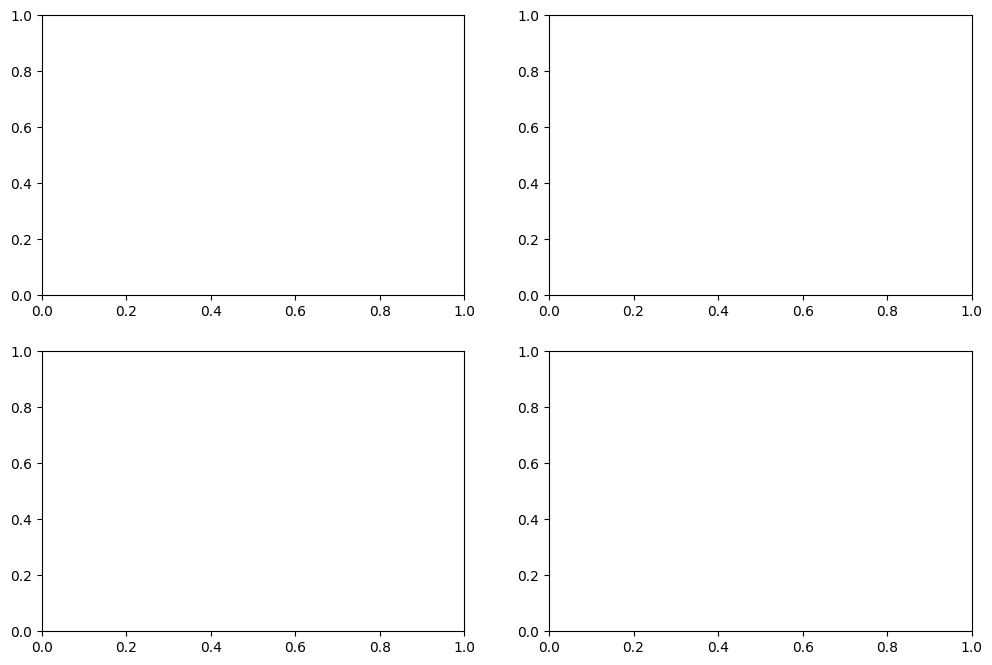

In [198]:
import math

class InefficiencyVisualizer:
    def __init__(self, hurst_calculator, datas: dict, dates: dict):
        """
        Paramètres:
            hurst_calculator: instance de HurstCalculator
            datas: dict, clé = nom de la série, valeur = pd.Series de prix indexée par date
            dates: dict, clé = date de début (string ou datetime), valeur = date de fin (string ou datetime)
        """
        self.hurst_calculator = hurst_calculator
        self.datas = datas
        self.dates = dates
        
    def plot_inefficiencies(self):
        """
        Pour chaque période définie dans self.dates, filtre chaque série de prix,
        calcule l'inefficience via HurstCalculator et affiche les résultats dans un subplot
        disposé sur deux colonnes.
        """
        # Pour chaque période à explorer
        for start_date, end_date in self.dates.items():
            # Filtrer chaque série sur la période et compter le nombre de séries
            filtered_datas = {}
            for label, series in self.datas.items():
                # Calculate the adjusted start date by subtracting window size in business days
                adjusted_start = pd.to_datetime(start_date) - pd.tseries.offsets.BDay(self.hurst_calculator.window)
                filtered_series = series.loc[adjusted_start:end_date]
                # Vérifier que la série n'est pas vide
                if not filtered_series.empty:
                    filtered_datas[label] = filtered_series
            n_series = len(filtered_datas)
            if n_series == 0:
                print(f"Aucune donnée pour la période {start_date} à {end_date}.")
                continue

            # Calcul du nombre de lignes pour 2 colonnes
            n_cols = 2
            n_rows = math.ceil(n_series / n_cols)
            
            # Création de la figure et des axes
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), squeeze=False)
            axes = axes.flatten()
            
            # Pour chaque série filtrée, calcul et tracé de l'inefficience
            for idx, (label, series) in enumerate(filtered_datas.items()):
                ineff_series, _ = self.hurst_calculator.calculate_inefficiency(series)
                ax = axes[idx]
                ax.plot(ineff_series.index, ineff_series.values, label=label)
                ax.set_title(f"{label}\n({start_date} à {end_date})")
                ax.set_xlabel("Date")
                ax.set_ylabel("Inefficience")
                ax.legend()
            
            # Supprimer les axes vides si nécessaire
            for j in range(idx + 1, len(axes)):
                fig.delaxes(axes[j])
            
            fig.suptitle(f"Inefficience de marché du {start_date} au {end_date}", fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

# Dictionnaire des périodes à explorer
dates = {
    '2007-01-01': '2009-06-01'
}

# Dictionnaire des séries (assurez-vous que ftse100, ftsemib, sp500, ssec sont des pd.Series)
datas = {
    's&p500': sp500,
    'ssec': ssec,
    'ftse100': ftse100,
    'ftsemib': ftsemib
}

# Calcul des inefficiences et de la volatilité pour chaque série
# Création de l'instance de HurstCalculator avec vos paramètres


# Création de l'instance de visualisation et affichage
visualizer = InefficiencyVisualizer(hurst_calculator=HurstCalculator(k=5, window=256, method="swv"), datas=datas, dates=dates)
visualizer.plot_inefficiencies()

In [172]:
res_tv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                         GLMGam   Df Residuals:                      490
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               Identity   Scale:                         0.48207
Method:                         PIRLS   Log-Likelihood:                -522.00
Date:                Fri, 11 Apr 2025   Deviance:                       236.21
Time:                        14:37:55   Pearson chi2:                     236.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              2.0346      0.031     65.408      0.000       1.974       2.096
x0_s0          0.0394      0.234      0.169      0.866      -0.418       0.497
x0_s1          0.0572      0.248      0.230      0.818      -0.429       0.544
x0_s2          0.0408      0.202      0.202      0.840      -0.355       0.437
x0_s3         -0.0432      0.191     -0.227      0.821      -0.417       0.330
x0_s4         -0.0596      0.191     -0.312      0.755      -0.434       0.315
x0_s5          0.2693      0.206      1.309      0.191      -0.134       0.673
x0_s6          0.0888      0.262      0.339      0.735      -0.425       0.603
x0_s7         -0.2445      0.280     -0.872      0.383      -0.794       0.305
x0_s8          0.0579      0.256      0.226      0.821      -0.444       0.560
==============================================================================
"""